<a href="https://colab.research.google.com/github/ayansengupta17/sequences_with_tf2/blob/main/sequences_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda x: x.batch(5))
dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y  in dataset:
    print(x.numpy(), y.numpy())

[[0 1 2 3]
 [4 5 6 7]] [[4]
 [8]]
[[3 4 5 6]
 [5 6 7 8]] [[7]
 [9]]
[[1 2 3 4]
 [2 3 4 5]] [[5]
 [6]]


In [22]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return time*slope

def seasonal_pattern(season_time):
    return np.where(season_time<0.4,
                    np.cos(season_time*2*np.pi),
                    1 / np.exp(3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) /period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [24]:
time = np.arange(4*365 + 1, dtype="float32")
amplitude = 40
slope = 0.05
noise_level = 5


In [25]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude) + noise(time, noise_level, seed=42)

In [26]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_val = time[split_time:]
x_val = series[split_time:]

In [32]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [30]:
def window_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda x: x.batch(window_size +1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [49]:
dataset = window_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
layer_0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([layer_0])

#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
model.fit(dataset, epochs=1000)
print(f"layer weights {layer_0.get_weights()}")

Epoch 1/1000
31/31 [==============================] - 0s 2ms/step - loss: 5618.3820
Epoch 2/1000
31/31 [==============================] - 0s 2ms/step - loss: 5623.1990
Epoch 3/1000
31/31 [==============================] - 0s 3ms/step - loss: 5637.8031
Epoch 4/1000
31/31 [==============================] - 0s 3ms/step - loss: 5316.6617
Epoch 5/1000
31/31 [==============================] - 0s 3ms/step - loss: 5374.5478
Epoch 6/1000
31/31 [==============================] - 0s 2ms/step - loss: 5189.0830
Epoch 7/1000
31/31 [==============================] - 0s 3ms/step - loss: 5210.2049
Epoch 8/1000
31/31 [==============================] - 0s 3ms/step - loss: 5202.1416
Epoch 9/1000
31/31 [==============================] - 0s 2ms/step - loss: 5540.3497
Epoch 10/1000
31/31 [==============================] - 0s 3ms/step - loss: 5296.0738
Epoch 11/1000
31/31 [==============================] - 0s 3ms/step - loss: 5365.1605
Epoch 12/1000
31/31 [==============================] - 0s 3ms/step - loss:

In [50]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time: time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))


<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

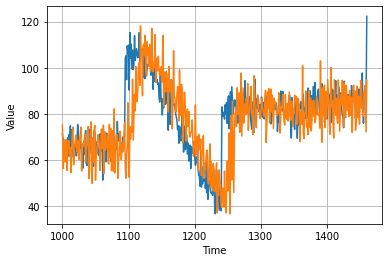

In [51]:
plot_series(time_val, x_val)
plot_series(time_val, results)

In [45]:
tf.keras.metrics.mean_absolute_error(x_val, results).numpy()

6.3074336